# Solving a Laplace problem with Dirichlet boundary conditions

### Background

In this tutorial we will solve a simple Laplace problem inside the unit sphere $\Omega$ with Dirichlet boundary conditions. The PDE is given by

$$
\Delta u = 0
$$

in $\Omega$ with boundary conditions 

$$
u = g
$$
on the boundary $\Gamma$ of $\Omega$. The boundary data is a source $\hat{u}$ located at the point $(.9,0,0)$.
$$
\hat{u}(\mathbf x)=\frac{1}{4\pi\sqrt{(x-.9)^2+y^2+z^2}}.
$$

For this example we will use an direct integral equation of the first kind. Let
$$
g(\mathbf x,\mathbf y) = \frac{1}{4\pi |\mathbf x-\mathbf y|}
$$
the Green's function in three dimensions with $|\mathbf x|^2=x^2+y^2+z^2$. Then from Green's representation theorem it follows that every function $u$ harmonic in $\Omega$ satisfies

$$
u(\mathbf x) = \int_{\Gamma} g(\mathbf x,\mathbf y)\frac{\partial u(\mathbf y)}{\partial n(\mathbf{y})}ds(\mathbf y)-\int_{\Gamma}\frac{\partial g(\mathbf x,\mathbf y)}{\partial n(\mathbf{y})}u(\mathbf y)ds(\mathbf y),~\mathbf x\in\Omega.
$$

Taking the limit $\mathbf x\rightarrow \Gamma$ we obtain the boundary integral equation

$$
\left[V\frac{\partial u}{\partial n}\right](\mathbf x)=\frac12 u(\mathbf x)+\left[Ku\right](\mathbf x),~\mathbf x\in\Gamma.
$$

Here, $V$ and $K$ are the single and double-layer potential boundary operators defined by

$$
\begin{align}
\left[V\phi\right](\mathbf x)&=\int_{\Gamma}g(\mathbf x,\mathbf y)\phi(\mathbf y)ds(y)\\
\left[K\phi\right](\mathbf x)&=\int_{\Gamma}\frac{\partial g(\mathbf x,\mathbf y)}{\partial n(\mathbf{y})}\phi(\mathbf y)ds(\mathbf y)
\end{align}
$$

for $x\in\Gamma$.


### Implementation

In the following we demonstrate how to solve this problem with BEM++. We first define the known Dirichlet boundary data. In this example we will use a Python function for it. Other ways are possible (such as a vector of coefficients at the nodes of a mesh).

In [1]:
import bempp.api
import numpy as np

def dirichlet_data(x, n, domain_index, result):
    result[0] = 1./(4 * np.pi * ((x[0] - .9)**2 + x[1]**2 + x[2]**2)**(0.5))


A valid Python function to define a BEM++ GridFunction takes the inputs `x`,`n`,`domain_index` and `result`. `x` is a three dimensional coordinate vector. `n` is the normal direction. The `domain_index` allows to identify different parts of a physical mesh in order to specify different functions on different subdomains. `result` is a Numpy array that will store the result of the function call. For scalar problems it just has one component `result[0]`.

We now define a mesh or grid in BEM++ notation. Normally one reads a grid from a file. BEM++ supports import and export to Gmsh with other data formats to follow soon. However, for this problem we do not need a complicated mesh but will rather use the built-in function `sphere` that defines a simple spherical grid.

In [2]:
grid = bempp.api.shapes.sphere(h=0.1)

We now define the spaces. For this example we will use two spaces, the space of continuous, piecewise linear functions and the space of piecewise constant functions. The space of piecewise constant functions has the right smoothness for the unknown Neumann data. We will use continuous, piecewise linear functions to represent the known Dirichlet data.

In [11]:
piecewise_const_space = bempp.api.function_space(grid, "DP", 0) # A disccontinuous polynomial space of order 0
piecewise_lin_space = bempp.api.function_space(grid, "P", 1)    # A continuous piecewise polynomial space of order 1

We can now define the operators. We need the identity operator, and the single-layer, respectively double-layer, boundary operator.  The general calling convention for an operator is

    op = factory_function(domain_space,range_space,dual_to_range_space,...)
    
Typically, for a Galerkin discretisation only the domain space and the dual space (or test space) are needed. BEM++ also requires a notion of the range of the operator. This makes it possible to define operator algebras in BEM++ that can be used almost as if the operators are continuous objects.

In [12]:
identity = bempp.api.operators.boundary.sparse.identity(
    piecewise_lin_space, piecewise_lin_space, piecewise_const_space)
dlp = bempp.api.operators.boundary.laplace.double_layer(
    piecewise_lin_space, piecewise_lin_space, piecewise_const_space)
slp = bempp.api.operators.boundary.laplace.single_layer(
    piecewise_const_space, piecewise_lin_space, piecewise_const_space)

We now define the GridFunction object on the sphere grid that represents the Dirichlet data.

In [13]:
dirichlet_fun = bempp.api.GridFunction(piecewise_lin_space, fun=dirichlet_data)

The below code will assemble the identity and double-layer boundary operator and evaluate the right-hand side of the boundary integral equation. This is an exact analogue of the underlying mathematical formulation. Depending on the grid size this command can take a bit since here the actual operators are assembled. The left-hand side only consists of the single-layer potential operator in this example. This is here not yet assembled as it is not yet needed. In BEM++ operators are only assembled once they are needed.

In [14]:
rhs = (.5*identity+dlp)*dirichlet_fun
lhs = slp

The following code solves the boundary integral equation iteratively using Conjugate Gradients. BEM++ offers a CG and GMRES algorithm. Internally these are just simple interfaces to the corresponding SciPy functions with the difference that the BEM++ variants accept BEM++ operators and GridFunctions as objects instead of just operators and vectors.

In [15]:
neumann_fun, info = bempp.api.linalg.cg(slp, rhs, tol=1E-3)

We now want to provide a simple plot of the solution in the (x,y) plane for z=0. First we need to define points at which to plot the solution.

In [16]:
n_grid_points = 150
plot_grid = np.mgrid[-1:1:n_grid_points*1j,-1:1:n_grid_points*1j]
points = np.vstack((plot_grid[0].ravel(),plot_grid[1].ravel(),np.zeros(plot_grid[0].size)))

The variable `points` now contains in its columns the coordinates of the evaluation points. We can now use Green's representation theorem to evaluate the solution on these points. Note in particular the last line of the following code. It is a direct implementation of Green's representation theorem.

In [17]:
slp_pot = bempp.api.operators.potential.laplace.single_layer(piecewise_const_space,points)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(piecewise_lin_space,points)
u_evaluated = slp_pot*neumann_fun-dlp_pot*dirichlet_fun

We now want to create a nice plot from the computed data. We only plot a slice through $z=0$. For a full three dimensional visualization BEM++ allows to export data to Gmsh. Since the solution decays quickly we will use a logarithmic plot.

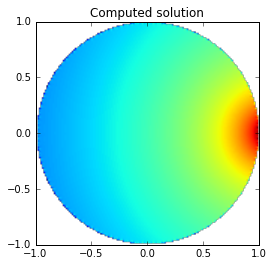

In [10]:
# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

# Filter out solution values that are associated with points outside the unit circle.
u_evaluated = u_evaluated.reshape((n_grid_points,n_grid_points))
radius = np.sqrt(plot_grid[0]**2+plot_grid[1]**2)
u_evaluated[radius>1] = np.nan

# Plot the image
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5.0, 4.0) # Adjust the figure size in IPython

from matplotlib import pyplot as plt

plt.imshow(np.log(np.abs(u_evaluated.T)), extent=(-1,1,-1,1),origin='lower')
plt.title('Computed solution')